In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.parser import parse
import string #To remove punctuation. NLP
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

metadata_file = "output/App_metadata.csv"
rel_notes_folder = "Automobile_extracts/"
NUM_SAMPLE_APPS = 30

# READ DATA

In [2]:
##Read metadata for automobile apps collected ( 30 apps from each category). 
df_metadata = pd.read_csv(metadata_file)
df_metadata
df_metadata["category"].unique() #Check categories, we are going to experiment on automotive
# array(['automotive', 'books', 'business', 'education', 'entertainment',
#        'family and relationship', 'finance', 'food', 'graphic and design',
#        'game', 'health and fitness', 'lifestyle', 'news and magazines',
#        'photo and video', 'real estate', 'shopping', 'social media',
#        'sports', 'travel', 'utility and productivity', 'games'],
#       dtype=object)

auto_meta_df = df_metadata[df_metadata["category"]== "automotive"]
auto_meta_df
app_names = auto_meta_df['title'].values

##Read the release notes of the apps

# Import libraries
import glob

# Get CSV files list from a folder
csv_files = glob.glob(rel_notes_folder + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = (pd.read_csv(file) for file in csv_files)

#Sort the dataframe according to date decreasing order
# for i in df_list:
#     i = i.sort_values(by=['Date'], ascending=False)

big_df = pd.DataFrame() # Create empty dataframe
for i in df_list:
#     #Sort the dataframe according to date decreasing order
#     for j in range(i.shape[0]):
#         i["Date"][j] = parse(i["Date"][j])
#     i = i.sort_values(by=['Date'], ascending=False)
    # Concatenate all DataFrames
    big_df = pd.concat([big_df,i], ignore_index=True)
big_df




,App,Ver,Date,Notes
0,Simply Auto: Car Maintenance &,50.1.1.1,"Mar 24, 2022",Bug fix for overlapping text
1,Simply Auto: Car Maintenance &,49.1.1.1,"Mar 10, 2022",-Updated save icon-Increased font size on the ...
2,Simply Auto: Car Maintenance &,48.1.1.1,"Feb 17, 2022",Bugfix for Total Cost calculation
3,Simply Auto: Car Maintenance &,47.1.1.3,"Feb 7, 2022","-Easy access to delete Vehicles, Fill-ups, ser..."
4,Simply Auto: Car Maintenance &,46.1.2.1,"Jan 22, 2022",- Fixed crashes- Fixed service type delete bug
...,...,...,...,...
751,CAR PROBLEMS AND REPAIRS,2.2.1,"Nov 2, 2020",Level improvements!
752,CAR PROBLEMS AND REPAIRS,2.2.0,"Oct 24, 2020",New mechanic and reward system come with this ...
753,CAR PROBLEMS AND REPAIRS,2.1.9,"Oct 15, 2020",New features and performance improvements!
754,CAR PROBLEMS AND REPAIRS,2.1.7,"Oct 8, 2020",Performance improvements!


In [3]:
big_df.describe(include = 'all')

,App,Ver,Date,Notes
count,750,754,752,750
unique,30,640,612,389
top,Android Auto,2.1.1,"Nov 18, 2022",• Improved Do Not Disturb functionality.\n• Da...
freq,105,5,5,83


In [4]:
big_df.info()
#Drop the rows with null data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   App     750 non-null    object
 1   Ver     754 non-null    object
 2   Date    752 non-null    object
 3   Notes   750 non-null    object
dtypes: object(4)
memory usage: 23.8+ KB


# PREPROCESSING

In [5]:
#Drop the rows with null data
big_df = big_df.dropna()
big_df.info()
big_df = big_df.reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 741 entries, 0 to 755
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   App     741 non-null    object
 1   Ver     741 non-null    object
 2   Date    741 non-null    object
 3   Notes   741 non-null    object
dtypes: object(4)
memory usage: 28.9+ KB


In [6]:
UNIQUE_ROWS = big_df.shape[0]
# Convert to the traditional release version
big_df = big_df.astype({'Ver':'string'}) #Convert from float to string      
for i in range(UNIQUE_ROWS):
    dot_count = big_df["Ver"][i].count('.')
#     print(dot_count)
    if dot_count ==0:
        big_df["Ver"][i] = big_df["Ver"][i]+".0.0" #append .0.0
    elif dot_count ==1:
        big_df["Ver"][i] = big_df["Ver"][i]+".0" #append .0
    dot_count = big_df["Ver"][i].count('.')
    if dot_count <2:  #Validation to check no non-traditional string
        print(big_df["Ver"][i])
    
#Add a column to find difference in dates
big_df.insert(loc = 4, column = "Time of Rel", value = np.nan, allow_duplicates=False)
for i in range(UNIQUE_ROWS - 1):
#     datetime.strptime(big_df["App"][i])
    parse(big_df["Date"][i])
    if big_df["App"][i] == big_df["App"][i + 1]:
#         datetime.strptime(date_string)
        delta = parse(big_df["Date"][i]) - parse(big_df["Date"][i + 1])
        if delta.days < 0:
            print(delta.days, "is differenc of", parse(big_df["Date"][i]), "and ", parse(big_df["Date"][i + 1]))
        else:
            big_df["Time of Rel"][i] = delta.days
big_df                

#Categorize them as major, minor, patch releases
big_df.insert(loc = 5, column = "Rel type", value = np.nan, allow_duplicates=False)
for i in range(UNIQUE_ROWS - 1):
    if big_df["App"][i] == big_df["App"][i + 1]:
        my_ver = big_df["Ver"][i]
        my_prev_ver = big_df["Ver"][i + 1]
#         if diff b/w number before 1st . is > 0:
        if int(my_ver.split(".")[0]) > int(my_prev_ver.split(".")[0]):
            big_df["Rel type"][i] = "Major"
#         elif diff b/w number after 1st before 2nd . is > 0:
        elif int(my_ver.split(".")[1]) > int(my_prev_ver.split(".")[1]):
            big_df["Rel type"][i] = "Minor"
        else:
            big_df["Rel type"][i] = "Patch"
    else: #it will bethe oldest rel note collected, so make it major. 
        big_df["Rel type"][i] = "Major"
big_df["Rel type"][UNIQUE_ROWS - 1] = "Major"
big_df 
big_df.info()

#Remove the first date in every app as we dont know the difference to its prev release.
# big_df = big_df.dropna()
# big_df.info()
# big_df = big_df.reset_index(drop=True)
# UNIQUE_ROWS = big_df.shape[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 741 entries, 0 to 740
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   App          741 non-null    object 
 1   Ver          741 non-null    string 
 2   Date         741 non-null    object 
 3   Notes        741 non-null    object 
 4   Time of Rel  711 non-null    float64
 5   Rel type     741 non-null    object 
dtypes: float64(1), object(4), string(1)
memory usage: 34.9+ KB


# Deriving Features

! pip uninstall stanfordcorenlp
! Conda uninstall stanfordcorenlp

In [7]:
# Stanford CoreNLP Lemmatization --Function definition'

# jahnavik$ cd Downloads/
# (base) Jahnavis-MacBook-Air:Downloads 
# jahnavik$ ls
# 1.csv					Rectangle0.66.dmg
# APPS_removed_duplicates - Apps.csv	Visual Studio Code-2.app
# Octoparse-8.5.8.dmg			Visual Studio Code.app
# R-4.2.2-arm64.pkg			cli.html
# RStudio-2022.12.0-353.dmg		stanford-corenlp-4.5.2
# (base) Jahnavis-MacBook-Air:Downloads 
# jahnavik$ cd stanford-corenlp-4.5.2/
# (base) Jahnavis-MacBook-Air:stanford-corenlp-4.5.2 
# jahnavik$ java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -annotators "tokenize,ssplit,pos,lemma,parse,sentiment" -port 9000 -timeout 30000
from stanfordcorenlp import StanfordCoreNLP
import json, string

def lemmatize_corenlp(conn_nlp, sentence):
    props = {
        'annotators': 'pos,lemma',
        'pipelineLanguage': 'en',
        'outputFormat': 'json'
    }

    # tokenize into words
    sents = conn_nlp.word_tokenize(sentence)

    # remove punctuations from tokenised list
    sents_no_punct = [s for s in sents if s not in string.punctuation]

    # form sentence
    sentence2 = " ".join(sents_no_punct)

    # annotate to get lemma
    parsed_str = conn_nlp.annotate(sentence2, properties=props)
    parsed_dict = json.loads(parsed_str)

    # extract the lemma for each word
    lemma_list = [v for d in parsed_dict['sentences'][0]['tokens'] for k,v in d.items() if k == 'lemma']

    # form sentence and return it
    return " ".join(lemma_list)
# make the connection and call `lemmatize_corenlp`
nlp = StanfordCoreNLP('http://localhost', port=9000, timeout=30000)

In [8]:
#reference: https://studymachinelearning.com/cosine-similarity-text-similarity-metric/
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

def create_dataframe(matrix, tokens):

    doc_names = [f'doc_{i+1}' for i, _ in enumerate(matrix)]
    df = pd.DataFrame(data=matrix, index=doc_names, columns=tokens)
    return(df)

def cos_similarity(data_1, data_2):
    data = [data_1, data_2]
    Tfidf_vect = TfidfVectorizer()
    vector_matrix = Tfidf_vect.fit_transform(data)
    tokens = Tfidf_vect.get_feature_names_out()
    create_dataframe(vector_matrix.toarray(),tokens)
    cosine_similarity_matrix = cosine_similarity(vector_matrix)
    df = create_dataframe(cosine_similarity_matrix,['data_1','data_2'])
    return df["data_1"][1]

In [9]:
#Find length, updatability, updatability for major releases
big_df.insert(loc = 6, column = "Length", value = np.nan, allow_duplicates=False)
for i in range(UNIQUE_ROWS):
    unique_words = set(big_df["Notes"][i].split())
    big_df["Length"][i] = len(unique_words)
big_df

#Remove punctuation. Stanford CoreNLP Lemmatization. Then cosine similarity b/w Ri and all prev rel. Updatability = 1 - cos simi
big_df.insert(loc = 7, column = "Processed Notes", value = np.nan, allow_duplicates=False)
for i in range(UNIQUE_ROWS):    
    big_df["Processed Notes"][i] = big_df["Notes"][i].translate(str.maketrans('', '', string.punctuation))
    big_df["Processed Notes"][i] = lemmatize_corenlp(conn_nlp=nlp, sentence=big_df["Processed Notes"][i])
big_df

big_df.insert(loc = 8, column = "Updatability", value = np.nan, allow_duplicates=False)
for i in range(UNIQUE_ROWS -1):
    if big_df["App"][i] == big_df["App"][i + 1]:
        data_1 = big_df["Processed Notes"][i]
        data_2 = big_df["Processed Notes"][i+1]
        big_df["Updatability"][i] = 1 - cos_similarity(data_1, data_2)
    else:
        big_df["Updatability"][i] = 1 #Oldest rel note we are assuming as unique
big_df["Updatability"][UNIQUE_ROWS-1] = 1 
big_df["Updatability"]

big_df.insert(loc = 9, column = "Updatability for Major Rel", value = np.nan, allow_duplicates=False)
for i in range(UNIQUE_ROWS -1):
    if big_df["App"][i] == big_df["App"][i + 1]:
        j = i + 1
        while(big_df["Rel type"][j] != "Major"):
            if ((j+1 in range(UNIQUE_ROWS)) and (big_df["App"][j] == big_df["App"][j + 1])):
                j = j + 1
            else:
                break
        if big_df["Rel type"][j] == "Major":
            data_1 = big_df["Processed Notes"][i]
            data_2 = big_df["Processed Notes"][j]
            big_df["Updatability for Major Rel"][i] = 1 - cos_similarity(data_1, data_2)
    else:
        big_df["Updatability for Major Rel"][i] = 1 #Oldest rel note we are assuming as unique
big_df["Updatability for Major Rel"][UNIQUE_ROWS-1] = 1 
big_df["Updatability for Major Rel"]
    

0      0.840261
1      1.000000
2      1.000000
3      0.732882
4      0.688743
         ...   
736    1.000000
737    1.000000
738    1.000000
739    1.000000
740    1.000000
Name: Updatability for Major Rel, Length: 741, dtype: float64

In [10]:
# big_df = big_df.drop(['Length'], axis=1)
# big_df = big_df.drop(['Updatability'], axis=1)
# big_df = big_df.drop(['Updatability for Major Rel'], axis=1)
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 741 entries, 0 to 740
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   App                         741 non-null    object 
 1   Ver                         741 non-null    string 
 2   Date                        741 non-null    object 
 3   Notes                       741 non-null    object 
 4   Time of Rel                 711 non-null    float64
 5   Rel type                    741 non-null    object 
 6   Length                      741 non-null    float64
 7   Processed Notes             741 non-null    object 
 8   Updatability                741 non-null    float64
 9   Updatability for Major Rel  741 non-null    float64
dtypes: float64(4), object(5), string(1)
memory usage: 58.0+ KB


In [11]:
#Remove the first date in every app as we dont know the difference to its prev release.
big_df = big_df.dropna()
big_df.info()
big_df = big_df.reset_index(drop=True)
UNIQUE_ROWS = big_df.shape[0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 711 entries, 0 to 739
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   App                         711 non-null    object 
 1   Ver                         711 non-null    string 
 2   Date                        711 non-null    object 
 3   Notes                       711 non-null    object 
 4   Time of Rel                 711 non-null    float64
 5   Rel type                    711 non-null    object 
 6   Length                      711 non-null    float64
 7   Processed Notes             711 non-null    object 
 8   Updatability                711 non-null    float64
 9   Updatability for Major Rel  711 non-null    float64
dtypes: float64(4), object(5), string(1)
memory usage: 61.1+ KB


In [12]:
#Spearman Rank Correlation Coefficient between Length, Updatability, Updatability for Major Rel
from scipy.stats import spearmanr
# calculate spearman's correlation
def SpearmanCorr(series1,series2):
    coef, p = spearmanr(series1, series2)
    print('Spearmans correlation coefficient: %.3f' % coef)
    # interpret the significance
    alpha = 0.0000 # 0.05
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)

print("Length and Updatability:")
SpearmanCorr(big_df["Length"], big_df["Updatability"])

print("\nLength and Updatability for Major Rel:")
SpearmanCorr(big_df["Length"], big_df["Updatability for Major Rel"])

print("\nUpdatability and Updatability for Major Rel:")
SpearmanCorr(big_df["Updatability"], big_df["Updatability for Major Rel"])

Length and Updatability:
Spearmans correlation coefficient: -0.095
Samples are uncorrelated (fail to reject H0) p=0.011

Length and Updatability for Major Rel:
Spearmans correlation coefficient: -0.119
Samples are uncorrelated (fail to reject H0) p=0.001

Updatability and Updatability for Major Rel:
Spearmans correlation coefficient: 0.688
Samples are uncorrelated (fail to reject H0) p=0.000


In [41]:
big_df.info()
big_df.to_csv("output/big_df.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   App                         711 non-null    object 
 1   Ver                         711 non-null    string 
 2   Date                        711 non-null    object 
 3   Notes                       711 non-null    object 
 4   Time of Rel                 711 non-null    float64
 5   Rel type                    711 non-null    object 
 6   Length                      711 non-null    float64
 7   Processed Notes             711 non-null    object 
 8   Updatability                711 non-null    float64
 9   Updatability for Major Rel  711 non-null    float64
dtypes: float64(4), object(5), string(1)
memory usage: 55.7+ KB


# RQ1: Release Note Update Patterns

In [13]:
auto_meta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   category   30 non-null     object 
 1   app_id     30 non-null     object 
 2   title      30 non-null     object 
 3   score      30 non-null     float64
 4   genre      30 non-null     object 
 5   price      30 non-null     float64
 6   free       30 non-null     bool   
 7   currency   30 non-null     object 
 8   developer  30 non-null     object 
 9   installs   30 non-null     object 
dtypes: bool(1), float64(2), object(7)
memory usage: 2.4+ KB


In [14]:
#Calculate Input Fetaures for (identifying Release note patterns using) K-means clustering.
import math
# Percentage of high value(above the third quartile)
# Ascending order. Third Quartile(Q3) = (3(n + 1)/4)th Term. Percentage of releases of an app with features above the third quantile

def percent_above_3rd_qartile(column_nm):
    auto_meta_df.insert(loc = auto_meta_df.shape[1], column = column_nm, value = np.nan, allow_duplicates=False)
    column_lst = big_df[column_nm].values.tolist() #Convert to list
    # print(type(column_lst))
    column_lst.sort() #Sort in ascending order
    # print(column_lst)
    n = len(column_lst) #Total values
    Q3 = column_lst[math.floor((3*(n + 1)/4)) -1] #Third quartile
    # for each app 
    for j in range(auto_meta_df.shape[0]):
        app = auto_meta_df["title"][j]
        total = 0 
        cent = 0 #Init % of values higher than Q3
        for i in range(UNIQUE_ROWS -1):
            if big_df["App"][i] == app:
                total = total + 1
                if big_df[column_nm][i] >= cent:
                    cent = cent + 1
        auto_meta_df[column_nm][j] = ((cent / total )*100) #% of values higher than Q3
percent_above_3rd_qartile("Length")
percent_above_3rd_qartile("Updatability")
percent_above_3rd_qartile("Updatability for Major Rel")
auto_meta_df["Length"]

0      36.000000
1      70.833333
2      95.833333
3     100.000000
4      79.166667
5      45.833333
6      66.666667
7      43.478261
8      87.500000
9      37.500000
10    100.000000
11     58.333333
12     79.166667
13     80.000000
14     87.500000
15    100.000000
16     54.166667
17    100.000000
18     72.727273
19     91.666667
20     62.500000
21     20.833333
22    100.000000
23     70.833333
24    100.000000
25    100.000000
26     95.833333
27     79.166667
28    100.000000
29     95.833333
Name: Length, dtype: float64

<Axes: >

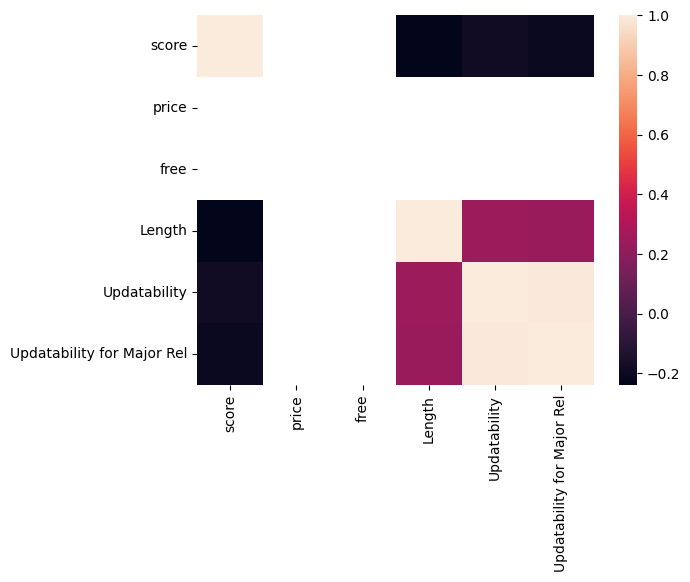

In [15]:
# Visualize.
import seaborn as sns
sns.heatmap(auto_meta_df.corr())

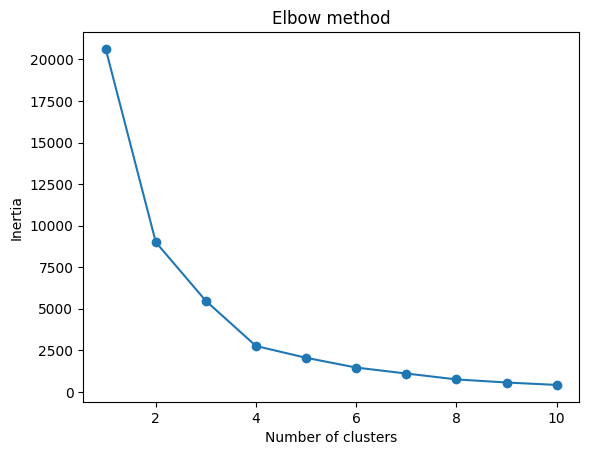

In [16]:
# ELbow method
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

data = list(zip(auto_meta_df["Length"], auto_meta_df["Updatability"],auto_meta_df["Updatability for Major Rel"] ))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [17]:
# K -means clustering
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np
# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
# to scale the data using z-score
from sklearn.preprocessing import StandardScaler
# to compute distances
from scipy.spatial.distance import cdist, pdist
# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
subset_lg=auto_meta_df[['title', 'Length', 'Updatability', 'Updatability for Major Rel']].copy()
for i in range(subset_lg.shape[0]): #Update title to index number
    subset_lg['title'][i] = i
scaler=StandardScaler()
subset_lg = subset_lg.drop(['title'], axis=1)
subset_int=subset_lg.copy()
# subset_int = subset_int.drop(['title'], axis=1)
# subset_int['Avg_Credit_Limit'] = np.log(subset_int['Avg_Credit_Limit'])
subset_interim=scaler.fit_transform(subset_int)
subset_scaled_interim=pd.DataFrame(subset_interim,columns=subset_lg.columns)
print(subset_scaled_interim)

      Length  Updatability  Updatability for Major Rel
0  -1.804208     -0.827006                   -0.773478
1  -0.273073     -0.027614                    0.017621
2   0.825828     -0.481814                   -0.431867
3   1.008979      0.275186                    0.317280
4   0.093228     -0.027614                   -0.431867
5  -1.371974     -0.027614                    0.017621
6  -0.456223     -0.027614                    0.017621
7  -1.475494      0.011881                    0.056707
8   0.459528     -0.481814                   -0.431867
9  -1.738274     -0.936014                   -0.881355
10  1.008979     -0.481814                   -0.431867
11 -0.822523     -0.027614                    0.017621
12  0.093228     -0.481814                   -0.431867
13  0.129858      1.244145                    1.276187
14  0.459528     -0.481814                   -0.431867
15  1.008979     -0.481814                   -0.431867
16 -1.005674     -0.481814                   -0.431867
17  1.0089

In [18]:
#Refrence: https://medium.com/mlearning-ai/deciding-number-of-clusters-using-gap-statistics-davies-bouldin-index-calinski-harabasz-index-2ce9acfb6118
from gap_statistic import OptimalK
from sklearn.cluster import KMeans
def KMeans_clustering_func(X, k):
    """ 
    K Means Clustering function, which uses the K Means model from sklearn.
    
    These user-defined functions *must* take the X (input features) and a k 
    when initializing OptimalK
    """
    
    # Include any clustering Algorithm that can return cluster centers
    
    m = KMeans(random_state=11, n_clusters=k)
    m.fit(X)
    
    # Return the location of each cluster center,
    # and the labels for each point.
    return m.cluster_centers_, m.predict(X)
#--------------------create a wrapper around OptimalK to extract cluster centers and cluster labels
optimalK = OptimalK(clusterer=KMeans_clustering_func)
#--------------------Run optimal K on the input data (subset_scaled_interim) and number of clusters
n_clusters = optimalK(subset_scaled_interim, cluster_array=np.arange(1, 15))
print('Optimal clusters: ', n_clusters)
#--------------------Gap Statistics data frame
optimalK.gap_df[['n_clusters', 'gap_value']]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in

Optimal clusters:  13


,n_clusters,gap_value
0,1.0,0.717692
1,2.0,0.780161
2,3.0,1.045666
3,4.0,1.587610
4,5.0,1.741164
5,6.0,1.913635
6,7.0,2.014924
7,8.0,2.053529
8,9.0,2.054560
9,10.0,2.182401


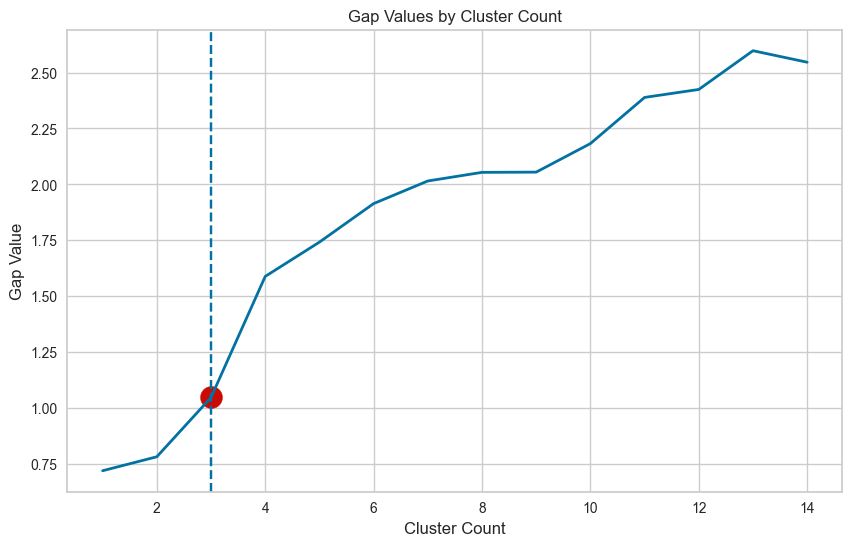

In [19]:
plt.figure(figsize=(10,6))
n_clusters=3
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=2)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.axvline(3, linestyle="--")
plt.show()

Optimum Number of clusters is 3 according to Gap Statistical method

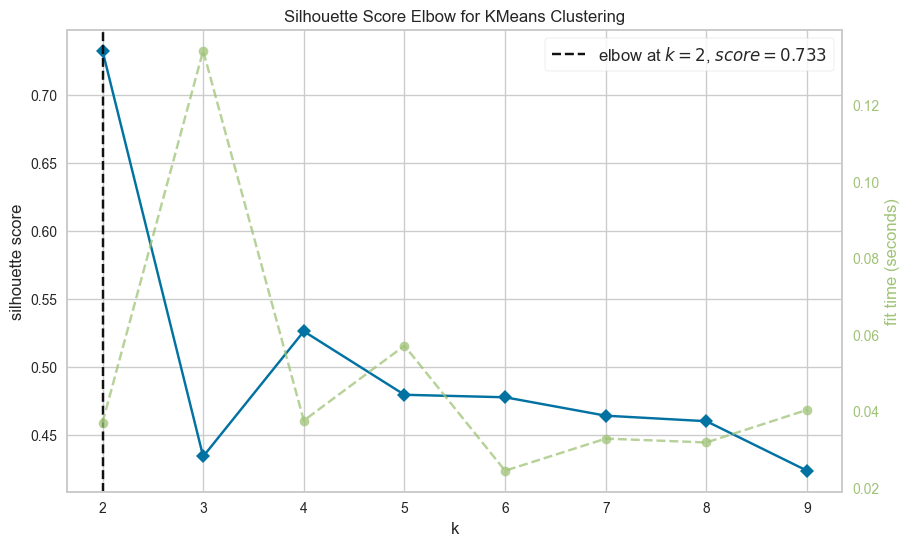

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [20]:
# Silhouette score for validation
#---------------------- Calinski Harabasz Score for K means
plt.figure(figsize=(10,6))
model = KMeans(random_state=1)
# k is a range of the number of clusters.
visualizer = KElbowVisualizer(
    model, k=(2, 10), metric="silhouette", timings=True
)
visualizer.fit(subset_scaled_interim)  # Fit the data to the visualizer
visualizer.show()  # Finalize and generate the plot

Silhouette score shows 2 clusters are optimal

In [21]:
# K means clustering --According to paper, let's go with 6 clusters
subset_scaled_interim
kmeans = KMeans(n_clusters=6)
kmeans.fit(subset_scaled_interim)
#The lower SSE value
print(kmeans.inertia_)
#Final location of centroids
print(kmeans.cluster_centers_)
# Number of iterations taken to converge
print(kmeans.n_iter_)
#Row to the cluster tagging
kmeans.labels_[:subset_scaled_interim.shape[0]]


4.9550133322124035
[[-0.1945799  -0.15738562 -0.23922926]
 [ 1.00897854  4.51438433  4.51250119]
 [ 0.84109086 -0.36826413 -0.35695231]
 [-1.1689162  -0.13129029 -0.08497949]
 [ 0.31633779  1.25882657  1.29071639]
 [-2.0044527  -0.74827801 -0.69556662]]
4


array([5, 0, 2, 2, 0, 3, 0, 3, 2, 5, 2, 3, 0, 4, 2, 2, 3, 2, 4, 2, 0, 5,
       4, 0, 2, 1, 2, 0, 2, 2], dtype=int32)

In [22]:
kmeans.labels_[:subset_scaled_interim.shape[0]]

array([5, 0, 2, 2, 0, 3, 0, 3, 2, 5, 2, 3, 0, 4, 2, 2, 3, 2, 4, 2, 0, 5,
       4, 0, 2, 1, 2, 0, 2, 2], dtype=int32)

#Analysis of clusters
Cluster 4: Long non-updating steady: App 3, 4, 9, 11, 15, 16, 18, 20, 25, 27, 29, 30
Cluster 3: Short rising-updatability with major releases: App 6, 8, 12, 17
Cluster 5: Long updating steady: App 26
Cluster 2: Short updating steady: App 14, 19, 23
Cluster 6: Long rising-updatability with major releases: App 2, 5, 7, 13, 21, 24, 28
Cluster 1: Short non-updating steady: App 1, 10, 22 

Summary: 50% of apps are non-updating. "bug", "improvemnets" general words are used in non-updating patterns. 

Manual analysis: 19 drivers for release:
General bug fix : Pattern 1
Detailed bug fix : Pattern 5
General improvement: Pattern 3 
Detailed improvement: Pattern 5
Performance: Pattern 4
New feature: Pattern 5, 6
Permission and security: Pattern 5
Platform Device Support: Pattern 5
UI: Pattern 6
Localization: Pattern 5
Crash: Pattern 5
Resource utilization: Pattern 4
Ask for feedback Advertisement: Pattern 4
Non informative: Pattern 4
Provide support: Pattern 5


# RQ2: Characteristics of apps v/s release note patterns

In [23]:
auto_meta_df

,category,app_id,title,score,genre,price,free,currency,developer,installs,Length,Updatability,Updatability for Major Rel
0,automotive,com.google.android.projection.gearhead,Android Auto,4.177981,Auto & Vehicles,0.0,True,INR,Google LLC,"1,000,000,000+",36.000000,1.000000,1.000000
1,automotive,com.carwale,CarWale: Buy-Sell New/Used Car,4.623589,Auto & Vehicles,0.0,True,INR,CarTrade Tech Limited,"5,000,000+",70.833333,8.333333,8.333333
2,automotive,gomechanic.retail,GoMechanic Car Services & More,4.365781,Auto & Vehicles,0.0,True,INR,"Car Services, Repairs, Auto Spares & Accessories","5,000,000+",95.833333,4.166667,4.166667
3,automotive,com.howacarworks,How a Car Works,3.768116,Books & Reference,0.0,True,INR,Cogniso Limited,"50,000+",100.000000,11.111111,11.111111
4,automotive,com.cuvora.carinfo,RTO Vehicle Information App,4.555693,Maps & Navigation,0.0,True,INR,Car Info,"10,000,000+",79.166667,8.333333,4.166667
5,automotive,mrigapps.andriod.fuelcons,Simply Auto: Car Maintenance &,4.500000,Auto & Vehicles,0.0,True,INR,Mobifolio,"500,000+",45.833333,8.333333,8.333333
6,automotive,com.playway.cms2017,Car Mechanic Simulator 21,4.243612,Simulation,0.0,True,INR,Digital Melody Games,"10,000,000+",66.666667,8.333333,8.333333
7,automotive,com.andromo.dev420527.app606734,CAR PROBLEMS AND REPAIRS,4.117647,Auto & Vehicles,0.0,True,INR,Ephiema,"1,000,000+",43.478261,8.695652,8.695652
8,automotive,com.autolauncher.motorcar.free,Car Launcher,4.296943,Auto & Vehicles,0.0,True,INR,apps lab studio,"1,000,000+",87.500000,4.166667,4.166667
9,automotive,com.zenthek.autozen,AutoZen-Car Dashboard&Launcher,4.000000,Auto & Vehicles,0.0,True,INR,ZenThek,"100,000+",37.500000,0.000000,0.000000


In [24]:
#Collect features to train LR models

#Create a df, copy category as app_category, installs as size_of_user_base and score as avg_rel_rating
rq2_df = pd.DataFrame(columns=['app_category', 'size_of_user_base', 'avg_rel_rating'])
rq2_df[['app_category', 'size_of_user_base', 'avg_rel_rating']] = auto_meta_df[['category', 'installs', 'score']].values
rq2_df
#Calcuate rel count, rel freq(median time to rel), same day releases
rq2_df.insert(loc = rq2_df.shape[1], column = 'rel_count', value = np.nan, allow_duplicates=False)
for i in range(auto_meta_df.shape[0]):
    rel_cnt = 0
    for j in range(big_df.shape[0]):
        if big_df['App'][j] == auto_meta_df['title'][i]:
            rel_cnt = rel_cnt + 1
    rq2_df['rel_count'][i] = rel_cnt

import statistics
rq2_df.insert(loc = rq2_df.shape[1], column = 'rel_freq', value = np.nan, allow_duplicates=False)
for i in range(auto_meta_df.shape[0]):
    rel_fq = 0
    time2rel_arr = []
    for j in range(big_df.shape[0]):
        if big_df['App'][j] == auto_meta_df['title'][i]:
            time2rel_arr.append(big_df['Time of Rel'][j])
    time2rel_arr.sort() #Sort in ascending order
    rel_fq = statistics.median(time2rel_arr)
    rq2_df['rel_freq'][i] = rel_fq

rq2_df.insert(loc = rq2_df.shape[1], column = 'same_day_rel', value = np.nan, allow_duplicates=False)
for i in range(auto_meta_df.shape[0]):
    samdy_rel = 0
    for j in range(big_df.shape[0]):
        if big_df['App'][j] == auto_meta_df['title'][i]:
            if big_df['Time of Rel'][j] == 0: #same day
                samdy_rel = samdy_rel + 1
    rq2_df['same_day_rel'][i] = samdy_rel

#Calculate % of releases with bug keywords, improvements keywords, emergency keywords. 
#If release notes have any of the value in array, then sum++. 
improve_keywords = ['improve', 'improved', 'improvements', 'enhance', 'enhances', 'update', 'updates', 'add', 'optimize']
bug_keywords = ['bug', 'bugs', 'fix', 'fixes', 'workaround', 'solve', 'resolved', 'problem', 'error', 'defect', 'incorrect', 'incorrectly', 'issue', 'issues', 'crash']
emergency_keywords = ['emergency', 'emergencies', 'urgent']
def word2vec(colmn_name, keywords):
    rq2_df.insert(loc = rq2_df.shape[1], column = colmn_name, value = np.nan, allow_duplicates=False)
    for i in range(auto_meta_df.shape[0]):
        imp_key = 0
        for j in range(big_df.shape[0]):
            if big_df['App'][j] == auto_meta_df['title'][i]:
                sentence = big_df['Notes'][j]
                words = sentence.split()
                for word in words:
                    if (word.lower() in keywords):
                        imp_key = imp_key + 1
                        break
        rq2_df[colmn_name][i] = imp_key
word2vec("improve_keywords", improve_keywords)
word2vec("bug_keywords", bug_keywords)
word2vec("emergency_keywords", emergency_keywords)
rq2_df
rq2_df.to_csv('output/rq2_df.csv')


,app_category,size_of_user_base,avg_rel_rating,rel_count,rel_freq,same_day_rel,improve_keywords,bug_keywords,emergency_keywords
0,automotive,"1,000,000,000+",4.177981,100.0,9.5,2.0,92.0,96.0,0.0
1,automotive,"5,000,000+",4.623589,24.0,17.5,0.0,9.0,22.0,0.0
2,automotive,"5,000,000+",4.365781,24.0,11.5,0.0,6.0,22.0,4.0
3,automotive,"50,000+",3.768116,9.0,9.0,1.0,5.0,4.0,0.0
4,automotive,"10,000,000+",4.555693,24.0,37.0,0.0,6.0,4.0,0.0
5,automotive,"500,000+",4.5,24.0,20.5,0.0,2.0,16.0,0.0
6,automotive,"10,000,000+",4.243612,24.0,12.0,0.0,16.0,17.0,0.0
7,automotive,"1,000,000+",4.117647,24.0,7.0,3.0,2.0,7.0,0.0
8,automotive,"1,000,000+",4.296943,24.0,33.0,0.0,1.0,21.0,0.0
9,automotive,"100,000+",4.0,24.0,8.0,0.0,0.0,24.0,0.0


In [28]:
#According to the RQ1 tagging, define Output variable as "with_Pattern"
# Cluster 4: Long non-updating steady: App 3, 4, 9, 11, 15, 16, 18, 20, 25, 27, 29, 30
# Cluster 3: Short rising-updatability with major releases: App 6, 8, 12, 17
# Cluster 5: Long updating steady: App 26
# Cluster 2: Short updating steady: App 14, 19, 23
# Cluster 6: Long rising-updatability with major releases: App 2, 5, 7, 13, 21, 24, 28
# Cluster 1: Short non-updating steady: App 1, 10, 22 
auto_meta_df.insert(loc = auto_meta_df.shape[1], column = "Pattern", value = np.nan, allow_duplicates=False)
for i in range(auto_meta_df.shape[0]):
    app_row = i + 1
    if app_row in [3, 4, 9, 11, 15, 16, 18, 20, 25, 27, 29, 3]:
        Pattern = 4
    elif app_row in [6, 8, 12, 17]:
        Pattern = 3
    elif app_row in [26]:
        Pattern = 5
    elif app_row in [14, 19, 23]:
        Pattern = 2
    elif app_row in [2, 5, 7, 13, 21, 24, 28]:
        Pattern = 6
    elif app_row in [1, 10, 22]:
        Pattern = 1
    auto_meta_df["Pattern"][i] = Pattern    
auto_meta_df
auto_meta_df.to_csv('output/auto_meta_df.csv')

In [26]:
#LR models for all patterns

#Create df for each pattern
def create_df_for_pat(p):
    this_df=rq2_df.copy()
    this_df.insert(loc = this_df.shape[1], column = "with_Pattern", value = 0, allow_duplicates=False)
    for i in range(auto_meta_df.shape[0]):
        if (auto_meta_df["Pattern"][i] == p):
            this_df["with_Pattern"][i] = 1
        if (auto_meta_df["category"][i] == 'automotive'):
            this_df["app_category"][i] = 1
    this_df["size_of_user_base"] = this_df["size_of_user_base"].str.replace("+","")
    this_df["size_of_user_base"] = this_df["size_of_user_base"].str.replace(",","")
    return this_df

rq2_1_df = create_df_for_pat(1).copy()
rq2_2_df = create_df_for_pat(2).copy()
rq2_3_df = create_df_for_pat(3).copy()
rq2_4_df = create_df_for_pat(4).copy()
rq2_5_df = create_df_for_pat(5).copy()
rq2_6_df = create_df_for_pat(6).copy()

rq2_1_df.to_csv('output/rq2_1_df.csv')
rq2_2_df.to_csv('output/rq2_2_df.csv')
rq2_3_df.to_csv('output/rq2_3_df.csv')
rq2_4_df.to_csv('output/rq2_4_df.csv')
rq2_5_df.to_csv('output/rq2_5_df.csv')
rq2_6_df.to_csv('output/rq2_6_df.csv')

# print(rq2_6_df["with_Pattern"])


In [30]:
# import pandas module 
import pandas as pd 
    
# making dataframe 
rq2_1_df = pd.read_csv("output/rq2_1_df.csv")
rq2_2_df = pd.read_csv("output/rq2_2_df.csv")
rq2_3_df = pd.read_csv("output/rq2_3_df.csv")
rq2_4_df = pd.read_csv("output/rq2_4_df.csv")
rq2_5_df = pd.read_csv("output/rq2_5_df.csv")
rq2_6_df = pd.read_csv("output/rq2_6_df.csv")

In [47]:
#LR models for all patterns
from  sklearn.metrics import confusion_matrix 
from sklearn.linear_model import LogisticRegression
clf_entropy = LogisticRegression()
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from scipy.stats import chi2
from sklearn.model_selection import train_test_split

def LR_model(df, p):
    print("\nFor pattern ",p)
    names = []
    for col in df.columns:
        if col!='with_Pattern':
                names.append(col)
    #Splitting independent data and targeted data as test and train
    X_train, X_test, Y_train, Y_test= train_test_split(df[names], df[["with_Pattern"]],test_size=0.1 ) 
    clf_entropy.fit(X_train,Y_train)
    # Compute the coefficients and intercept of the logistic regression model
    predicted_entropy = clf_entropy.predict(X_test)
    coef = clf_entropy.coef_[0]
    intercept = clf_entropy.intercept_
    cM = confusion_matrix(Y_test,predicted_entropy)
    fpr, tpr, thresholds = roc_curve(Y_test,predicted_entropy)
    aucP=auc(fpr, tpr)
    print('auc of ROC curve =', aucP)
    # Compute the design matrix and residuals
    X = X_train.values
    y = Y_train.values.ravel()
    y_pred = clf_entropy.predict(X)
    residuals = y - y_pred

    # Compute the mean squared error
    MSE = np.mean(residuals ** 2)
    MSE = float(MSE)  # convert to float
    # Compute the standard errors of the coefficients
    # XtX_inv = np.linalg.inv(X.T @ X)
    #  SE = np.sqrt(np.diag(XtX_inv) * MSE)
    XtX_pinv = np.linalg.pinv(X.T @ X)
    SE = np.sqrt(np.diag(XtX_pinv) * MSE)


    # Compute the Wald statistics and p-values
    Wald = (coef / SE) ** 2
    p_values = chi2.sf(Wald, 1)

    # # Print the results
    # for i in range(len(names)):
    #     print(f"{names[i]}: Wald = {Wald[i]:.2f}, p-value = {p_values[i]:.2e}")
    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'Variable': names,
        'Wald statistic': Wald,
        'p-value': p_values
    })
    # Print the results
    return results_df


Wald_rq2_1_df = LR_model(rq2_1_df, 1)
Wald_rq2_1_df
Wald_rq2_1_df.to_csv('output/Wald_rq2_1_df.csv')
Wald_rq2_2_df = LR_model(rq2_2_df, 2)
Wald_rq2_2_df.to_csv("output/Wald_rq2_2_df.csv")
Wald_rq2_3_df = LR_model(rq2_3_df, 3)
Wald_rq2_3_df.to_csv("output/Wald_rq2_3_df.csv")
Wald_rq2_4_df = LR_model(rq2_4_df, 4)
Wald_rq2_4_df.to_csv("output/Wald_rq2_4_df.csv")
Wald_rq2_5_df = LR_model(rq2_5_df, 5)
Wald_rq2_5_df.to_csv("output/Wald_rq2_5_df.csv")
Wald_rq2_6_df = LR_model(rq2_6_df, 6)
Wald_rq2_6_df.to_csv("output/Wald_rq2_6_df.csv")


For pattern  1
auc of ROC curve = 0.5

For pattern  2
auc of ROC curve = nan

For pattern  3
auc of ROC curve = nan

For pattern  4
auc of ROC curve = 0.5

For pattern  5
auc of ROC curve = nan

For pattern  6
auc of ROC curve = 0.5


Summary:
Pattern 1,4,6 are performing better than rest according to AUC of ROC value.

Wald statis- tics (χ2) to estimate the relative contribution of each app attribute:
Pattern 1: rel_freq, avg_rel_rating, improve_keywords, bug_keywords
Pattern 2: nan
Pattern 3: size_of_user_base, emergency_keywords, improve_keywords
Pattern 4: emergency_keywords, avg_rel_rating, same_day_rel
Pattern 5: size_of_user_base, bug_keywords, rel_freq
Pattern 6: size_of_user_base, emergency_keywords, avg_rel_rating, same_day_rel

Pattern-1: Tend to have lower rating. Bug/improve keywords used. They mention generalised sentences.
Pattern-2: lower rating. Improvement keywords
Pattern-3: less downloads, higher emergency fixes.
Pattern-4: medium release ratings. Same day fixes are high, so emergency keywords are used.
Pattern-5: high release ratings. Infrequnently deployed
Pattern-6: high release ratings. Response rate is high. 

# RQ3: Release note pattern shifts

In [49]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   App                         711 non-null    object 
 1   Ver                         711 non-null    string 
 2   Date                        711 non-null    object 
 3   Notes                       711 non-null    object 
 4   Time of Rel                 711 non-null    float64
 5   Rel type                    711 non-null    object 
 6   Length                      711 non-null    float64
 7   Processed Notes             711 non-null    object 
 8   Updatability                711 non-null    float64
 9   Updatability for Major Rel  711 non-null    float64
dtypes: float64(4), object(5), string(1)
memory usage: 55.7+ KB


In [62]:
#Represent length, updatability and updaability for major rel as "time series"

#Check if the last 5 release values are greater than the average value of the app
def is_greater_than_avg(colmn):
    increase_arr = []
    for j in range(auto_meta_df.shape[0]):
        curr_val = 0
        iter = 5
        for i in range(big_df.shape[0]):
            if (iter <= 0):
                break
            elif (big_df["App"][i] == auto_meta_df['title'][j]):
                if curr_val < big_df[colmn][i]:
                    curr_val = big_df[colmn][i]
                iter = iter - 1
        # print(j,"th app has current value ", curr_val, "whereas avg is", auto_meta_df[colmn][j] )
        if(curr_val > auto_meta_df[colmn][j]):
            increase_arr.append(j + 1)
    return increase_arr

Len_inc_arr = is_greater_than_avg("Length")
print(Len_inc_arr)
Updat_inc_arr = is_greater_than_avg("Updatability")
print(Updat_inc_arr)
Update4Maj_inc_arr = is_greater_than_avg("Updatability for Major Rel")
print(Update4Maj_inc_arr)

# inc_arr = []
inc_arr = np.concatenate((Len_inc_arr, Updat_inc_arr, Update4Maj_inc_arr))
inc_arr


[3, 5, 20, 23, 27]
[]
[]


array([ 3.,  5., 20., 23., 27.])

Summary:

Apps 3, 5, 20, 23, 27 feature values have increased recently. 

Manual analysis:
App 3: Description regarding services offered, new functionalities. Asking for feedback. --Not much of pattern shift
App 5: Short to Long shift. non-freq updatability to frq updatabity. How to use the fuctionalities is described. 
App 20: Short to Long shift. non-freq updatability to frq updatabity. Describing impovements made in detail instead of general description. 
App 23: Short to Long. BUT, specific to generic. Freq updatability to non-freq updatability. 
App 27: Description regarding services offered, new functionalities. Asking for feedback. --Not much of pattern shift

To summarize:
Most apps switch from short to Long release note patterns. 
66% of (pattern shifted) apps have shifted from rarelyy updated to frequently updated type. 
i.e., Most of them have started giving instructions on usage to users, asking for feedback, swicthed from general description to specific details. 